In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
prob = 0.5
dropout = nn.Dropout(p=prob)
x = torch.ones(10)

y = dropout(x)

print(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([2., 2., 2., 2., 2., 0., 2., 2., 2., 0.])
tensor(1.6000)


Dropout is turned off during evaluation

In [3]:
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


Unexpectedly, turning our model's eval mode on does not affect the dropout function in the functional module

In [4]:
dropout.eval()
y = F.dropout(x)
print(y)

tensor([2., 2., 2., 0., 0., 2., 0., 2., 0., 2.])


But we can turn it on by setting the `training` parameter to **False**

In [5]:
y = F.dropout(x, training=False)
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


Below cell proves that you have to remember to turn training mode on to turn on dropout

In [6]:
dropout.train()
y = dropout(x)
print(y)

dropout.eval()
y = dropout(x)
print(y)

y = dropout(x)
print(y)

tensor([0., 0., 2., 0., 2., 0., 2., 0., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


# Regularization in practice
## Create the data

In [7]:
n_per_cluster = 200

theta = np.linspace(0, 4 * np.pi, n_per_cluster)
r1 = 10
r2 = 15

a = np.array(
    [
        r1 * np.cos(theta) + np.random.rand(n_per_cluster) * 3,
        r1 * np.sin(theta) + np.random.rand(n_per_cluster),
    ]
)
b = np.array(
    [
        r2 * np.cos(theta) + np.random.rand(n_per_cluster),
        r2 * np.sin(theta) + np.random.rand(n_per_cluster) * 3,
    ]
)
print(f"Shape of a: {a.shape}, shape of b: {b.shape}")

labels = np.vstack((np.zeros((n_per_cluster, 1)), np.ones((n_per_cluster, 1))))
print(f"Shape of labels: {labels.shape}")

data_matrix = np.hstack((a, b)).transpose()
print(f"Shape of data matrix: {data_matrix.shape}")

data_tensor = torch.tensor(data_matrix).float()
labels_tensor = torch.tensor(labels).float()

Shape of a: (2, 200), shape of b: (2, 200)
Shape of labels: (400, 1)
Shape of data matrix: (400, 2)


In [8]:
labels

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [9]:
data_tensor.shape

torch.Size([400, 2])

In [10]:
np.where(labels == 1)

(array([200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
        213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
        226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
        239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
        252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
        304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
        317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
        330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
        343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
        356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
        369, 370, 371, 372, 373, 374, 375, 376, 377

In [11]:
data_tensor[(np.arange(200), np.zeros(200))]

tensor([10.1542, 10.5545, 10.3721, 12.1777, 10.6743, 11.1145, 12.1071, 10.7285,
         9.5235, 10.8737,  9.2933,  8.4817,  9.7237,  8.0273,  8.7073,  5.8557,
         6.9228,  6.4165,  5.5686,  6.1750,  3.3799,  2.9070,  3.2332,  4.1416,
         2.3832,  1.6695,  0.8865,  0.2106,  0.9309, -1.5463, -0.9136, -1.0860,
        -3.6781, -3.8291, -4.4245, -3.0329, -4.3289, -5.4254, -5.6874, -7.2869,
        -7.0810, -7.3313, -7.6265, -8.4850, -8.0286, -8.0375, -6.7812, -9.4048,
        -7.3511, -9.0854, -8.1899, -8.7463, -7.4874, -6.9900, -7.7314, -8.2677,
        -8.5394, -8.6602, -6.1485, -6.3651, -4.9829, -7.2782, -6.9064, -5.1168,
        -5.3249, -4.4294, -4.7821, -4.1378, -3.5687, -1.4870, -1.5951,  0.6393,
        -1.3515,  0.8147,  0.6187,  2.0986,  1.5057,  1.8744,  2.5642,  3.7725,
         4.1391,  6.8958,  4.8237,  5.5442,  7.0066,  7.6930,  7.4784,  7.2446,
         8.9770, 10.0648,  9.7149, 10.1214, 10.0887, 10.8415, 10.6848, 12.4944,
        12.0405, 10.7628, 11.7479, 12.01

In [12]:
data_tensor[np.where(labels == 0)]

tensor([10.1542, 10.5545, 10.3721, 12.1777, 10.6743, 11.1145, 12.1071, 10.7285,
         9.5235, 10.8737,  9.2933,  8.4817,  9.7237,  8.0273,  8.7073,  5.8557,
         6.9228,  6.4165,  5.5686,  6.1750,  3.3799,  2.9070,  3.2332,  4.1416,
         2.3832,  1.6695,  0.8865,  0.2106,  0.9309, -1.5463, -0.9136, -1.0860,
        -3.6781, -3.8291, -4.4245, -3.0329, -4.3289, -5.4254, -5.6874, -7.2869,
        -7.0810, -7.3313, -7.6265, -8.4850, -8.0286, -8.0375, -6.7812, -9.4048,
        -7.3511, -9.0854, -8.1899, -8.7463, -7.4874, -6.9900, -7.7314, -8.2677,
        -8.5394, -8.6602, -6.1485, -6.3651, -4.9829, -7.2782, -6.9064, -5.1168,
        -5.3249, -4.4294, -4.7821, -4.1378, -3.5687, -1.4870, -1.5951,  0.6393,
        -1.3515,  0.8147,  0.6187,  2.0986,  1.5057,  1.8744,  2.5642,  3.7725,
         4.1391,  6.8958,  4.8237,  5.5442,  7.0066,  7.6930,  7.4784,  7.2446,
         8.9770, 10.0648,  9.7149, 10.1214, 10.0887, 10.8415, 10.6848, 12.4944,
        12.0405, 10.7628, 11.7479, 12.01

In [13]:
data_tensor[np.where(labels == 0)[0], 0]

tensor([10.1542, 10.5545, 10.3721, 12.1777, 10.6743, 11.1145, 12.1071, 10.7285,
         9.5235, 10.8737,  9.2933,  8.4817,  9.7237,  8.0273,  8.7073,  5.8557,
         6.9228,  6.4165,  5.5686,  6.1750,  3.3799,  2.9070,  3.2332,  4.1416,
         2.3832,  1.6695,  0.8865,  0.2106,  0.9309, -1.5463, -0.9136, -1.0860,
        -3.6781, -3.8291, -4.4245, -3.0329, -4.3289, -5.4254, -5.6874, -7.2869,
        -7.0810, -7.3313, -7.6265, -8.4850, -8.0286, -8.0375, -6.7812, -9.4048,
        -7.3511, -9.0854, -8.1899, -8.7463, -7.4874, -6.9900, -7.7314, -8.2677,
        -8.5394, -8.6602, -6.1485, -6.3651, -4.9829, -7.2782, -6.9064, -5.1168,
        -5.3249, -4.4294, -4.7821, -4.1378, -3.5687, -1.4870, -1.5951,  0.6393,
        -1.3515,  0.8147,  0.6187,  2.0986,  1.5057,  1.8744,  2.5642,  3.7725,
         4.1391,  6.8958,  4.8237,  5.5442,  7.0066,  7.6930,  7.4784,  7.2446,
         8.9770, 10.0648,  9.7149, 10.1214, 10.0887, 10.8415, 10.6848, 12.4944,
        12.0405, 10.7628, 11.7479, 12.01

In [14]:
example_tensor = torch.tensor([[2, 4], [6, 8], [10, 12], [14, 16]])
example_tensor

tensor([[ 2,  4],
        [ 6,  8],
        [10, 12],
        [14, 16]])

In [15]:
example_tensor.shape

torch.Size([4, 2])

In [16]:
example_tensor[(0, 1, 2, 3), 0]

tensor([ 2,  6, 10, 14])

In [17]:
example_array = np.array([[0, 1], [2, 3], [0, 4]])
example_array

array([[0, 1],
       [2, 3],
       [0, 4]])

In [18]:
np.where(example_array == 0)

(array([0, 2]), array([0, 0]))

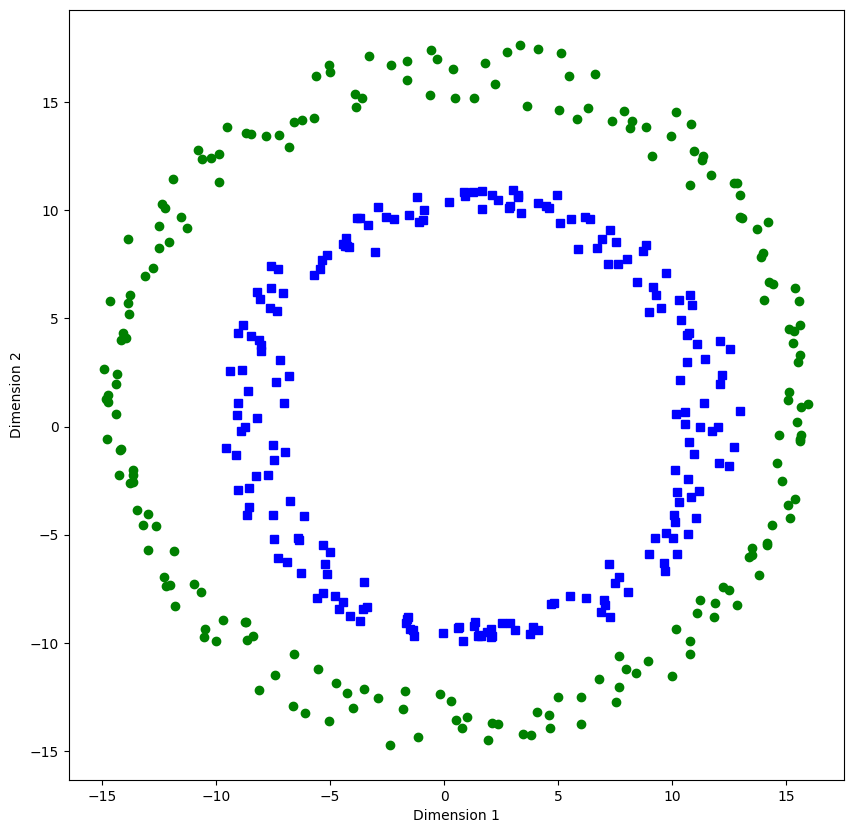

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(
    data_tensor[np.where(labels == 0)[0], 0],
    data_tensor[np.where(labels == 0)[0], 1],
    "bs",
)
ax.plot(
    data_tensor[np.where(labels == 1)[0], 0],
    data_tensor[np.where(labels == 1)[0], 1],
    "go",
)

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")

plt.show()

In [20]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_tensor, labels_tensor, test_size=0.2
)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])